In [21]:
import csv
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import TimeSeriesSplit

import lightgbm as lgb

import seaborn as sns

In [25]:
building_metadata = pd.read_csv("data/building_metadata.csv")
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")
weather_test = pd.read_csv("data/weather_test.csv")
weather_train = pd.read_csv("data/weather_train.csv")

In [26]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [27]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
weather_train = reduce_mem_usage(weather_train)
weather_test = reduce_mem_usage(weather_test)
building = reduce_mem_usage(building_metadata)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)


In [28]:
le = LabelEncoder()
building.primary_use = le.fit_transform(building.primary_use)

In [40]:
def prepare_data(X, building, weather, test = False):
    """
    Data cleaning and feature engineering
    """
    
    X = X.merge(building, on="building_id", how="left")
    X = X.merge(weather, on=["site_id", "timestamp"], how="left")
    
    X.timestamp = pd.to_datetime(X.timestamp, format="%Y-%m-%d %H:%M:%S")
    X.square_feet = np.log1p(X.square_feet)
    
    if not test:
        X.sort_values("timestamp", inplace=True)
        X.reset_index(drop=True, inplace=True)
        
    holidays = ["2016-01-01", "2016-01-18", "2016-02-15", "2016-05-30", "2016-07-04",
                "2016-09-05", "2016-10-10", "2016-11-11", "2016-11-24", "2016-12-26",
                "2017-01-01", "2017-01-16", "2017-02-20", "2017-05-29", "2017-07-04",
                "2017-09-04", "2017-10-09", "2017-11-10", "2017-11-23", "2017-12-25",
                "2018-01-01", "2018-01-15", "2018-02-19", "2018-05-28", "2018-07-04",
                "2018-09-03", "2018-10-08", "2018-11-12", "2018-11-22", "2018-12-25",
                "2019-01-01"]
    
    X["hour"] = X.timestamp.dt.hour
    X["weekday"] = X.timestamp.dt.weekday
    X["month"] = X.timestamp.dt.month
    X["is_holiday"] = (X.timestamp.dt.date.astype("str").isin(holidays)).astype(int)
    X["building_age"] = X.timestamp.dt.year - X.year_built
    
    if test:
        row_ids = X.row_id
        X.drop("row_id", axis=1, inplace=True)
        return X, row_ids
    else:
        y = np.log1p(X.meter_reading)
        X.drop("meter_reading", axis=1, inplace=True)
        return X, y

In [41]:
X_train, y_train = prepare_data(train, building, weather_train)

In [42]:
X_train.head()

,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,weekday,month,is_holiday,building_age
0,0,0,2016-01-01,0,0,8.913685,2008.0,NaN,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000,0,4,1,1,8.0
1,1104,1,2016-01-01,13,9,12.204687,NaN,NaN,-8.296875,8.0,-12.203125,NaN,1023.5,250.0,4.101562,0,4,1,1,NaN
2,1104,0,2016-01-01,13,9,12.204687,NaN,NaN,-8.296875,8.0,-12.203125,NaN,1023.5,250.0,4.101562,0,4,1,1,NaN
3,1103,0,2016-01-01,13,7,10.081801,NaN,NaN,-8.296875,8.0,-12.203125,NaN,1023.5,250.0,4.101562,0,4,1,1,NaN
4,1102,2,2016-01-01,13,6,11.375822,NaN,NaN,-8.296875,8.0,-12.203125,NaN,1023.5,250.0,4.101562,0,4,1,1,NaN


In [43]:
X_test, row_ids = prepare_data(test, building, weather_test, test=True)

In [44]:
gc.collect()

5926

In [45]:
del train, weather_train

In [46]:
y_train = y_train[X_train.building_id != 1099]
X_train = X_train[X_train.building_id != 1099]

X_train.drop("timestamp", axis=1, inplace=True)
X_test.drop("timestamp", axis=1, inplace=True)

X_train.drop("precip_depth_1_hr", axis=1, inplace=True)
X_test.drop("precip_depth_1_hr", axis=1, inplace=True)

X_train.drop("floor_count", axis=1, inplace=True)
X_test.drop("floor_count", axis=1, inplace=True)

X_train.drop("cloud_coverage", axis=1, inplace=True)
X_test.drop("cloud_coverage", axis=1, inplace=True)

X_train.drop("primary_use", axis=1, inplace=True)
X_test.drop("primary_use", axis=1, inplace=True)

In [47]:
nsplits = 3
folds = TimeSeriesSplit(nsplits)

In [48]:
categorical_features = ["building_id","site_id", "meter",  "hour","month","weekday"]

params = {
    "objective": "regression",
    "boosting": "gbdt",
    "max_depth": -1,
    "num_leaves": 1000,
    "learning_rate": 0.1,
    "feature_fraction": 0.95,
    "reg_lambda": 2,
    "max_bin": 550,
    "metric": "rmse"
}

pred = np.zeros(len(X_test))

In [49]:
df_fimp = pd.DataFrame()
for tr_idx,va_idx in folds.split(X_train,y_train):
    X_half_1 = X_train.iloc[tr_idx]
    y_half_1 = y_train.iloc[tr_idx]
    X_half_2 = X_train.iloc[va_idx]
    y_half_2 = y_train.iloc[va_idx]

    d_half_1 = lgb.Dataset(X_half_1, label=y_half_1, categorical_feature=categorical_features, free_raw_data=False)
    d_half_2 = lgb.Dataset(X_half_2, label=y_half_2, categorical_feature=categorical_features, free_raw_data=False)

    print("Building model with first half and validating on second half:")
    model_half = lgb.train(params, train_set=d_half_1, num_boost_round=300, valid_sets=[d_half_1,d_half_2], verbose_eval=100, early_stopping_rounds=50)
    gc.collect()
    pred += np.expm1(model_half.predict(X_test, num_iteration=model_half.best_iteration)) / nsplits
    
    df_fimp_1 = pd.DataFrame()
    df_fimp_1["feature"] = X_train.columns.values
    df_fimp_1["importance"] = model_half.feature_importance()
    
    df_fimp = pd.concat([df_fimp, df_fimp_1], axis=0)
    del model_half
    gc.collect()


Building model with first half and validating on second half:


/Users/jasminabajramovic/miniconda3/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  A numpy array with information from the Dataset.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's rmse: 0.818831	valid_1's rmse: 1.44394
Building model with first half and validating on second half:
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	training's rmse: 0.94247	valid_1's rmse: 1.4431
Building model with first half and validating on second half:
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 0.605718	valid_1's rmse: 1.15905
[200]	training's rmse: 0.556289	valid_1's rmse: 1.15701
Early stopping, best iteration is:
[180]	training's rmse: 0.562691	valid_1's rmse: 1.15529


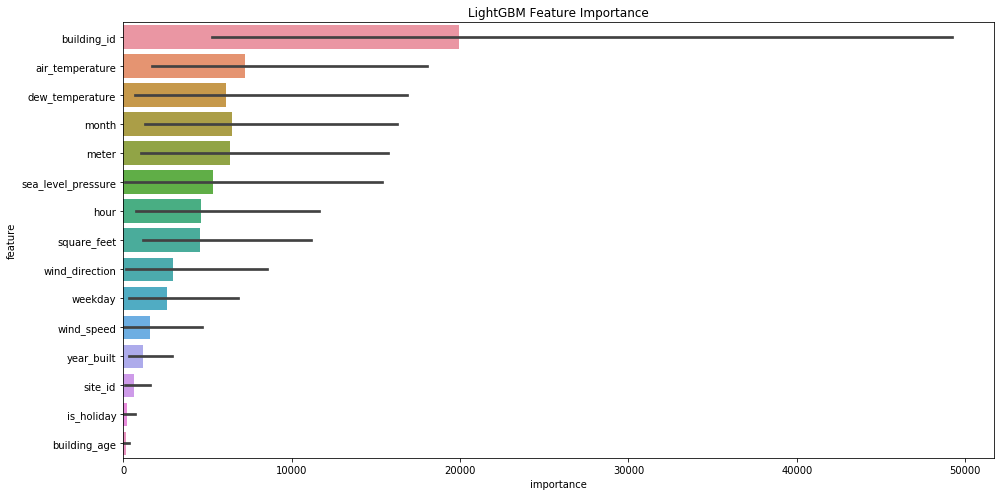

In [50]:
plt.figure(figsize=(14, 7))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()